## Explaining Models with LIME and SHAP

[Victor Dibia](https://twitter.com/vykthur). Research Engineer, Cloudera Fast Forward Labs.
May 8, 2020

At  [Cloudera Fast Forward](https://www.cloudera.com/products/fast-forward-labs-research.html), we see model interpretability as an important step in the data science workflow. Being able to explain how a model works serves many purposes, including building trust in the model's output, satisfying regulatory requirements, model debugging, and verifying model safety, amongst other things. We have written a research report (access it free here) that discusses this topic in detail.
In this article, we revisit two industry standard algorithms for interpretability - LIME and SHAP. We discuss how these two algorithms work, and show some code examples of how to implement them in python. At the end of this post, you should be familiar with: 

- An overview of model interpretability
- Interpreting white box models, such as Linear/Logistic Regression (using model coefficients) and Tree models (using feature importance scores)
- Interpreting black box models with LIME and SHAP (KernelExplainer, TreeExplainer) and how to implement this in python
- Good practices for "debugging" LIME and SHAP explanations
- Limitations of LIME/SHAP (a.k.a., when to choose LIME over SHAP)

In [ ]:
# Install dependencies
!pip3 install -r requirements.txt

In [ ]:
# Download data
!curl -L -O https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

In [2]:
# This cell is necessary if running this project on a CDSW workspace
import sys
sys.path = [p for p in sys.path if 'parcels' not in p]

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import umap
import xgboost
from lime.lime_tabular import LimeTabularExplainer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [5]:
idcol = "customerID"
labelcol = "Churn"
cols = (
    ("gender", True),
    ("SeniorCitizen", True),
    ("Partner", True),
    ("Dependents", True),
    ("tenure", False),
    ("PhoneService", True),
    ("MultipleLines", True),
    ("InternetService", True),
    ("OnlineSecurity", True),
    ("OnlineBackup", True),
    ("DeviceProtection", True),
    ("TechSupport", True),
    ("StreamingTV", True),
    ("StreamingMovies", True),
    ("Contract", True),
    ("PaperlessBilling", True),
    ("PaymentMethod", True),
    ("MonthlyCharges", False),
    ("TotalCharges", False),
)


def drop_non_features(df, cols):
    return df[[c for c, _ in cols]]


def drop_missing(df):
    """Remove rows with missing values"""
    return df.replace(r"^\s$", np.nan, regex=True).dropna()


def clean(df):
    # Make target variable a true boolean column
    # Drop unpredictive column
    df.drop(["customerID"], axis=1)


def categorize(df, cols):
    catcols = (c for c, iscat in cols if iscat)
    for col in catcols:
        df[col] = pd.Categorical(df[col])
    return df


def booleanize_senior_citizen(df):
    """Make SeniorCitizen 'Yes'/'No' like other columns in this dataset."""
    return df.replace({"SeniorCitizen": {1: "Yes", 0: "No"}})


def splitdf(df, label):
    return df.drop(label, axis=1), df[label]


def load_dataset():
    """Return IBM customers and labels."""
    df = pd.read_csv("Telco-Customer-Churn.csv")
    df = drop_missing(df).reset_index()
    df.index.name = "id"
    features, labels = splitdf(df, labelcol)
    features = booleanize_senior_citizen(features)
    features = drop_non_features(features, cols)
    features = categorize(features, cols)
    labels = labels == "Yes"
    return features, labels


def setup_plot():
    plt.rcParams["axes.grid.axis"] = "y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc("grid", linestyle="dashed", color="lightgrey", linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"] = 15

## The Dataset (Customer Churn)

For this post, we illustrate our discussion using a public dataset of 7,043 cable customers, around 25% of whom churned. There are 20 features for each customer, which are a mixture of intrinsic attributes of the person or home (gender, family size, etc.) and quantities that describe their service or activity (payment method, monthly charge, etc.).

- The dataset contains both continuous and categorical features.

- Depending on the type of model, we can make different decisions on how categorical fields are represented. For example, tree-based models can be trained directly with categorical features (label encoded), while other models (e.g. Logistic regression, Neural Networks) work better with one hot encoded categorical variables. 





In [6]:
data, labels = load_dataset()

# Get categorical column indexes
cat_columns_ix_ = {
    c: i
    for i, c in enumerate(data.columns)
    if pd.api.types.is_categorical_dtype(data[c])
}
# categorical column names
cat_columns = [c for c in (data.columns) if pd.api.types.is_categorical_dtype(data[c])]

# Make copies of data with various representations for categorical features.
data_numeric = data.copy()  # categorical fields are label encoded but numerical
data_categorical = (
    data.copy()
)  # categorical fields are label encoded, numeric but categorical type
data_ohe = pd.get_dummies(
    data, columns=cat_columns, sparse=False
)  # categorical fields are one hot encoded

# Convert categorical columns to numeric encoded labels
for col in cat_columns:
    data_numeric[col] = LabelEncoder().fit_transform(data_numeric[col])
    data_categorical[col] = data_numeric[col].astype("category")


# Set data used for explorations
# Hint .. Change this to other version of the data and observe changes in results.
current_data = data_categorical
print("Available features: \n", list(data_categorical.columns))
print("Label Balance - [No Churn, Churn] : ", list(labels.value_counts()))

Available features: 
 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
Label Balance - [No Churn, Churn] :  [5163, 1869]


## What are General Patterns in the Dataset?
It is often useful to visually explore the relationship between input features and output labels. This gives some idea on the complexity of the problem and might inform the choice of model to explore. 

- Correlation Plots

We can explore [pair plots](https://seaborn.pydata.org/generated/seaborn.pairplot.html) visualizations of continuous variables in the dataset. To reduce computational complexity of these plots some features are binned and replaced with their mean value. A quick review of results here suggests that customers who churned appear to have higher monthly charges.

- Dimensionality Reduction

As a first step, we can apply both linear ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) and non-linear ([UMAP](https://umap-learn.readthedocs.io/en/latest/)) dimensionality reduction techniques to features in the dataset.

Results from [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [UMAP](https://umap-learn.readthedocs.io/en/latest/) are shown below. 
Both methods are used to reduce the dimension of the input feature to two dimensions and visualized as a scatter plot. Note that PCA results do not show any clear separation between  data points of churn vs no churn customers (for the given amount of variance explained). This suggests models capable of modeling non-linear patterns are more suitable to this task. 

<Figure size 1440x720 with 0 Axes>

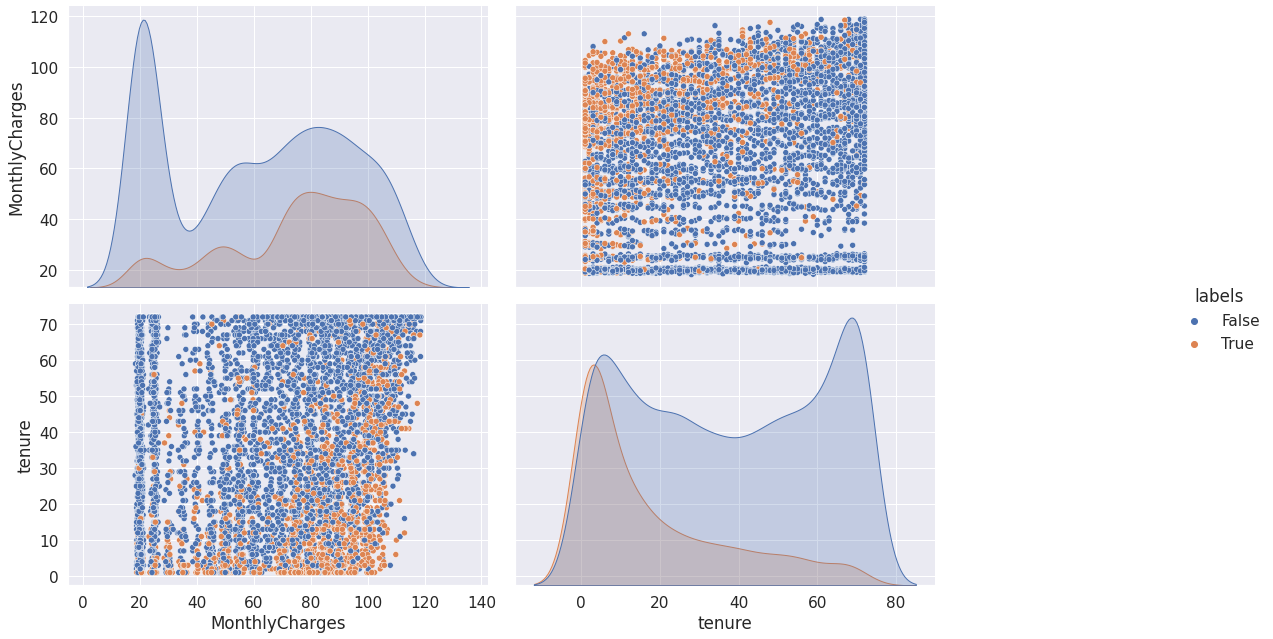

In [7]:
fig = plt.figure(figsize=(20, 10))

# Create the df for  pairplot
sns_df = current_data[["MonthlyCharges", "tenure"]].copy()
sns_df["labels"] = [str(x) for x in labels.values]


# Bin the totalCharges column into 5 bins. Replace by mean of bin interval
n_bins = 5
sns.set(font_scale=1.4)
total_charges = current_data["TotalCharges"].astype(float)
lower, higher = int(total_charges.min()), int(total_charges.max())
edges = range(lower, higher, int((higher - lower) / n_bins))
lbs = [(edges[i] + edges[i + 1]) / 2 for i in range(len(edges) - 1)]
sns_df["totalCharges"] = pd.cut(
    total_charges, bins=n_bins, labels=lbs, include_lowest=True
)

# Plot data usig pairplot
ax = sns.pairplot(sns_df, diag_kind="kde", hue="labels")
ax.fig.set_size_inches(20, 10)

Explained variation per principal component:  0.999981870392923 (7032, 2)
 > PCA Complete =========== (7032, 19)
Explained variation per principal component:  0.3443542888475112 (7032, 2)
 > PCA Complete =========== (7032, 19)


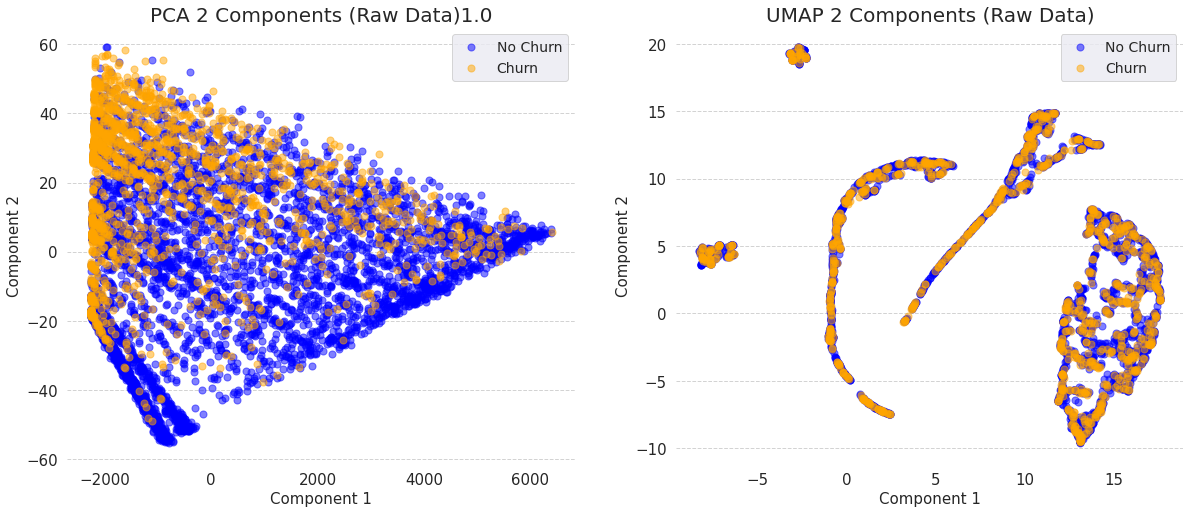

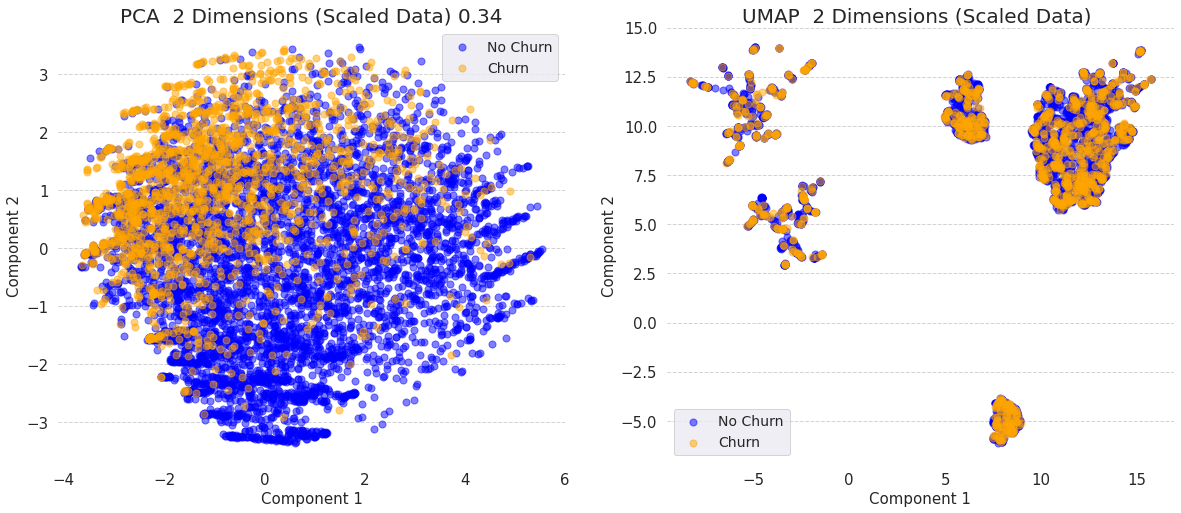

In [8]:
def reduce_dimensions_umap(df):
    reducer = umap.UMAP(metric="cosine")
    # restrict number of samples due to scipy.sparse limitation
    embedding = reducer.fit_transform(df.sample(4095, axis=0))
    return embedding
 
# reduce dimensions via pca
def reduce_dimensions_pca(df, num_features):
    num_features = min(num_features, df.shape[1])
    pca = PCA(n_components=num_features)
    pca = pca.fit(df.values)
    pca_result = pca.transform(df.values)
    print("Explained variation per principal component: ",
          np.sum(pca.explained_variance_ratio_), pca_result.shape)
    print(" > PCA Complete ===========", df.shape)
    return pca, pca_result

def visualize_dims(fig, fig_index, pca_vals, labels, title):
    col_names = [ "pc" +str(e) for e in range(1, pca_vals.shape[1] +1 )] 
    pdpca = pd.DataFrame(pca_vals, columns=col_names)
    pdpca["label"]  = labels

    # Plot PCA values

    ax = fig.add_subplot(1,2, fig_index) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    targets = list(labels.unique())
    colors = ['blue', 'orange']
    for target, color in zip(targets,colors):
        indicesToKeep = pdpca['label'] == target 
        ax.scatter(pdpca.loc[indicesToKeep, 'pc1']
                   , pdpca.loc[indicesToKeep, 'pc2']
                   , c = color
                   , alpha = 0.5
                   , s = 50)
    ax.legend(["No Churn", "Churn"])  

scaler = StandardScaler()
scaled_current_data = pd.DataFrame(scaler.fit_transform(current_data))

# compute pca and umap projections
def plot_dim_reduction(data, scale_status):
    num_components = 2 
    # visualize projections
    setup_plot()
    fig = plt.figure(figsize = (20,8))
    pca, pca_vals = reduce_dimensions_pca(data, num_components)
    visualize_dims(fig, 1, pca_vals, labels, "PCA " + scale_status +  str(round(np.sum(pca.explained_variance_ratio_),2)) ) 
    plt.box(False)

    umap_vals = reduce_dimensions_umap(data)
    visualize_dims(fig, 2, umap_vals, labels, "UMAP " + scale_status)
    plt.box(False) 

# Note the PCA visualization only is useful for
# inferring properties in the data if 2 component pca 
# explains a large amount of variance.
plot_dim_reduction(current_data, "2 Components (Raw Data)"  )
plot_dim_reduction(scaled_current_data,  " 2 Dimensions (Scaled Data) " )


## Model Training

We can train a set of models on the churn dataset and compare their performance. To simplify this process, we will use the sklearn library and utilize the `model.fit()` api to train the model while recording train and test accuracy. The following models are trained:

- Naive Bayes
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosted Tree 
- Multilayer Perceptron

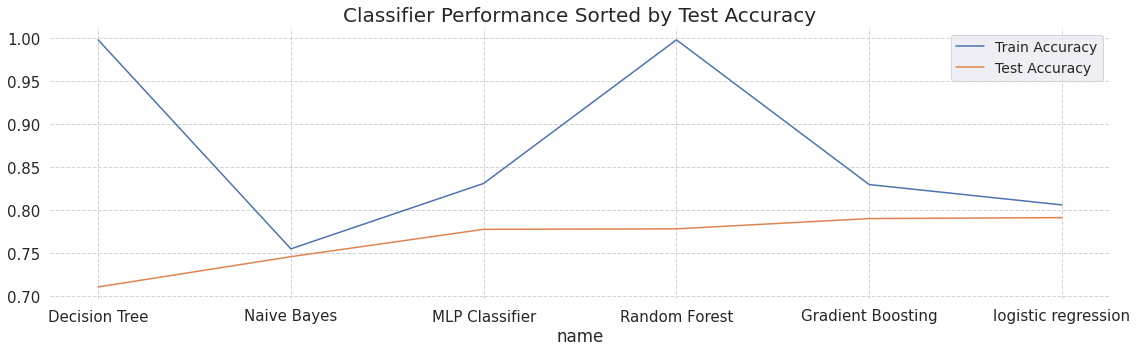

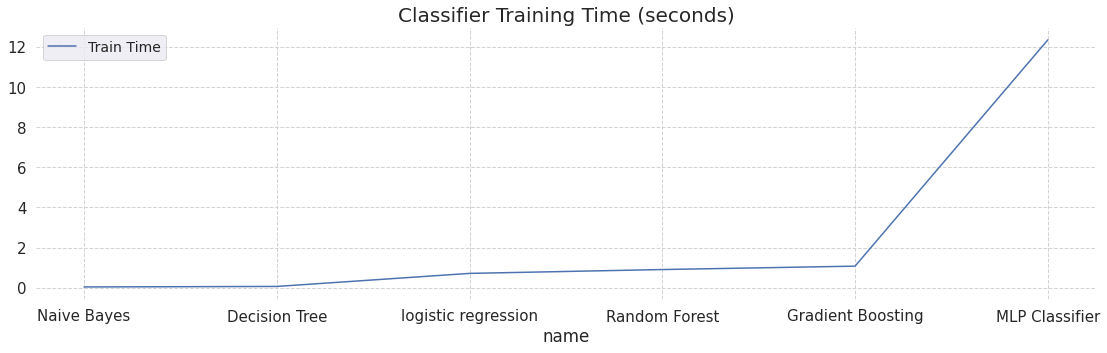

In [9]:
trained_models = [] #  keep track of all details for models we train

def train_model(model, data, labels): 
    X = data
    y = labels.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time

    train_accuracy =  pipe.score(X_train, y_train)
    test_accuracy = pipe.score(X_test, y_test) 
    model_details = {"name": model["name"], "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
    return model_details

models = [
          {"name": "Naive Bayes", "clf": GaussianNB()},
          {"name": "logistic regression", "clf": LogisticRegressionCV()}, 
          {"name": "Decision Tree", "clf": DecisionTreeClassifier()},
          {"name": "Random Forest", "clf": RandomForestClassifier(n_estimators=100)},
          {"name": "Gradient Boosting", "clf": GradientBoostingClassifier(n_estimators=100)}, 
          {"name": "MLP Classifier", "clf": MLPClassifier(solver='adam', alpha=1e-1, hidden_layer_sizes=(10,10,5,2), max_iter=500, random_state=42)}]

for model in models:
    model_details = train_model(model, current_data, labels) 
    trained_models.append(model_details)


# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models)
model_df.sort_values("test_accuracy", inplace=True) 
ax = model_df[["train_accuracy","test_accuracy", "name"]].plot(kind="line", x="name", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
for p in ax.patches:
    ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.title.set_size(20)
plt.box(False)

model_df.sort_values("train_time", inplace=True)
ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)  

Figure shows a) Performance performance of 6 classifiers. While the (untuned) Decision tree and Random Forest models have high train accuracy, they don’t perform so well on the test set, indicating **overfitting** for this problem. Gradient boosted Tree and Logistic regression have a good balance of train/test accuracy for this dataset. b) Training time.

## Explaining Models

At this point, we have a few models trained, and we can use them to obtain predictions. Given the data for each cable customer, we can predict the probability that they will churn. However, what is not very clear is how each of these features contribute to the predicted churn probability. We can think of these explanations in **global** terms (i.e., how does each feature impact outcomes on the average for the entire datasheet?) or in **local** terms (i.e., how does each feature impact predictions for a given customer?).
Some models have inbuilt properties that provide these sorts of explanations. These are typically referred to as **white box** models and examples include linear regression (model coefficients), logistic regression (model coefficients) and decision trees (feature importance). Due to their complexity, other models - such as Random Forests, Gradient Boosted Trees, SVMs, Neural Networks etc. - do not have straightforward methods for explaining their predictions. For these models, (also known as **black box** models), approaches such as LIME and SHAP can be applied.





### Global Explanation - Logistic Regression Coefficients
For models such as linear and logistic regression, we can look at the model coefficients to infer feature importance (note that coefficients need to be  [interpreted](https://web.ma.utexas.edu/users/mks/statmistakes/regressioncoeffs.html) with [care](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/) for each model type).  This gives us some idea of how an increase/change in each feature might result in a change in the log odds that the customer will churn. We can also get a general understanding of how important a feature is for the entire dataset.

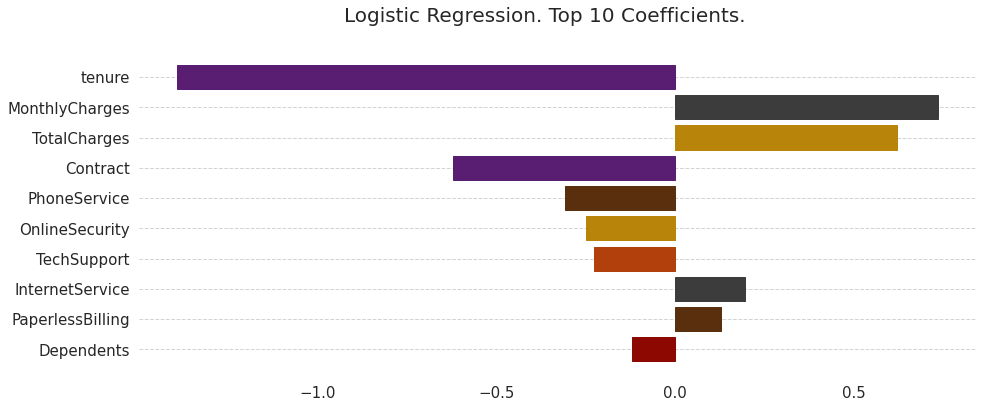

In [10]:
plt.figure(figsize=(15,6))

X_train, X_test, y_train, y_test = train_test_split(current_data, labels.values, random_state=42)

logistic_reg_coeff = trained_models[1]["model"]["clf"].coef_
color_list =  sns.color_palette("dark", len(current_data.columns)) 
top_x = 10
logistic_reg_coeff = trained_models[1]["model"]["clf"].coef_[0]
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1] 
lreg_ax = plt.barh(current_data.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])

for i,bar in enumerate(lreg_ax):
    bar.set_color(color_list[idx[:top_x][::-1][i]])
    plt.box(False)

lr_title = plt.suptitle("Logistic Regression. Top " + str(top_x) + " Coefficients.", fontsize=20, fontweight="normal")

# Explanations via Feature Importance Scores [Tree Based Models]

Tree-based models have properties that let us infer the importance of a feature. For each decision tree, we can compute the mean decrease in impurity for each feature - i.e., how impactful the feature is in reducing the uncertainty (classifiers) or variance (regressors) of the decision tree prediction. This value is also known as the gini importance score. For each tree based model in our list of trained models, we can leverage the sklearn `feature_importance` implementation and visualize the average importance of each variable.


Text(0.5, 0.98, 'Feature Importance for Tree Models. Top 10 Features.')

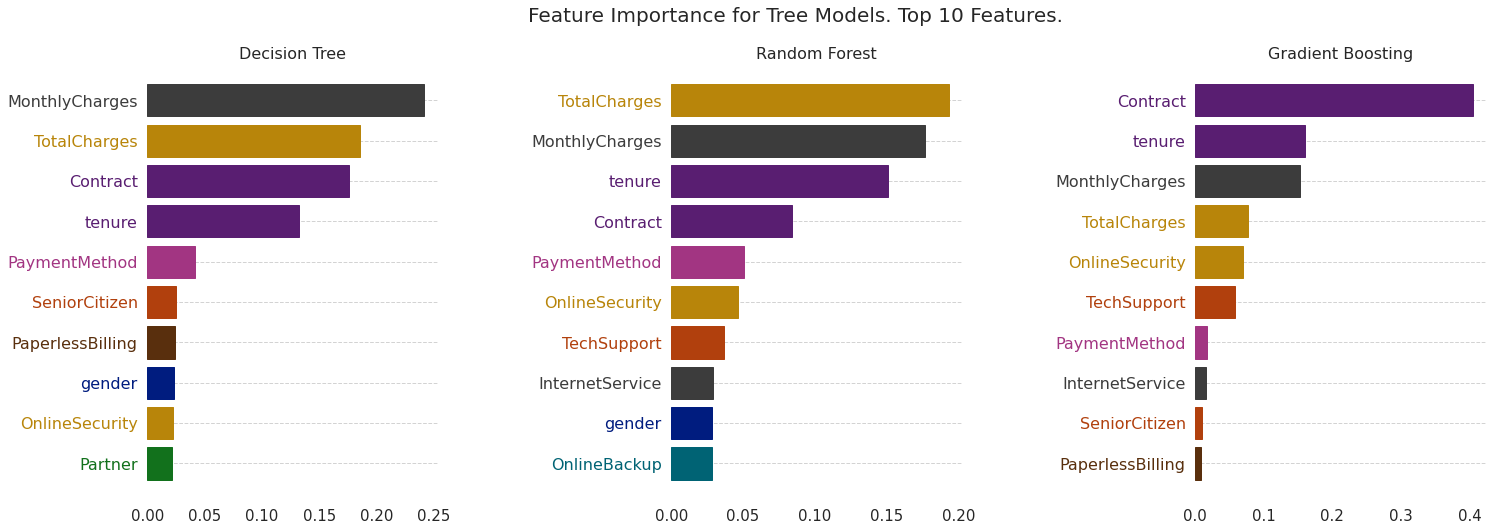

In [11]:
# Create array of tree based models and plot feature importance scores
tree_models = []
setup_plot()
color_list = sns.color_palette("dark", len(current_data.columns))
top_x = 10  # number of x most important features to show
for model in trained_models:
    if hasattr(model["model"]["clf"], "feature_importances_"):
        tree_models.append(
            {"name": model["name"], "fi": model["model"]["clf"].feature_importances_}
        )


fig, axs = plt.subplots(1, 3, figsize=(24, 8), facecolor="w", edgecolor="k")
fig.subplots_adjust(hspace=0.5, wspace=0.8)
axs = axs.ravel()
for i in range(len(tree_models)):
    feature_importance = tree_models[i]["fi"]
    indices = np.argsort(feature_importance)
    indices = indices[-top_x:]

    bars = axs[i].barh(
        range(len(indices)), feature_importance[indices], color="b", align="center"
    )
    axs[i].set_title(tree_models[i]["name"], fontweight="normal", fontsize=16)

    plt.sca(axs[i])
    plt.yticks(
        range(len(indices)),
        [current_data.columns[j] for j in indices],
        fontweight="normal",
        fontsize=16,
    )

    # print(len(plt.gca().get_yticklabels()), len(indices))
    for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
        ticklabel.set_color(color_list[indices[i]])

    for i, bar in enumerate(bars):
        bar.set_color(color_list[indices[i]])
    plt.box(False)

plt.suptitle(
    "Feature Importance for Tree Models. Top " + str(top_x) + " Features.",
    fontsize=20,
    fontweight="normal",
)

These feature importance values look interesting. All 3 models appear to consistently rank `Monthly Charges`, `Total Charges`, `Contract` and `Tenure` in the top 5 salient features, suggesting they are important features. 

There are several limitations here. 
- The feature importance scores are relative, making it hard to interpret with respect to the predicted outcome. While they tell us that `Total Charges` is relatively more important than Contract for the Decision Tree model, they do not tell us how much a 1$ USD increase in `Total Charges` impacts the probability of a customer churning.
- Feature importance measures are global estimates across the entire training dataset. For a subset of customers, within the same model, the order and magnitude of feature importance may change (see the section below on local instance explanations). Thus, while we know `Total Charges` are important on the average we cannot confidently answer the question:  how does Total Charges affect a specific customer?

- There are known biases related to how the feature importance score is computed. See ([Bias in random forest variable importance measures: Illustrations, sources and a solution](https://link.springer.com/article/10.1186%2F1471-2105-8-25))


These limitations make it desirable to explore local explanations.


## Explanations with LIME

Local Interpretable Model-agnostic Explanation ([LIME](https://arxiv.org/abs/1602.04938)) provides a fast and relatively simple method for `locally` explaining black box models. The LIME algorithm can be simplified into a few steps

- For a given data point, randomly perturb its features repeatedly. For tabular data, this entails adding a small amount of noise to each feature.  
- Get predictions for each perturbed data instance. This helps us build up a local picture of the decision surface at that point.
- Use predictions to compute an approximate linear "explanation model" using predictions. Coefficients of the linear model are used as explanations.


The LIME python library provides interfaces for explaining models built on tabular (TabularExplainer), image (LimeImageExplainer), and text data (LimeTextExplainer). 

In the following section, we will attempt to explain predictions from a single test data instance for all our trained models using the LimeTabularExplainer.


## LIME Tabular Explainer: Explain a test data instance for all models

In the following section, we will generate and visualize lime explanations for a given data point in our test set. We will do this for all our trained models.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    current_data, labels, random_state=42
)


def get_lime_explainer(model, data, labels):
    cat_feat_ix = [
        i
        for i, c in enumerate(data.columns)
        if pd.api.types.is_categorical_dtype(data[c])
    ]
    feat_names = list(data.columns)
    class_names = list(labels.unique())
    scaler = model["model"]["scaler"]
    data = scaler.transform(data)  # scale data to reflect train time scaling
    lime_explainer = LimeTabularExplainer(
        data,
        feature_names=feat_names,
        class_names=class_names,
        categorical_features=cat_feat_ix,
        mode="classification",
    )
    return lime_explainer


def lime_explain(explainer, data, predict_method, num_features):
    explanation = explainer.explain_instance(
        data, predict_method, num_features=num_features
    )
    return explanation


lime_data_explainations = []
lime_metrics = []
lime_explanation_time = []
feat_names = list(current_data.columns)
test_data_index = 6
for current_model in trained_models:
    scaler = current_model["model"]["scaler"]
    scaled_test_data = scaler.transform(X_test)
    predict_method = current_model["model"]["clf"].predict_proba

    start_time = time.time()
    # explain first sample from test data
    lime_explainer = get_lime_explainer(current_model, X_train, y_train)
    explanation = lime_explain(
        lime_explainer, scaled_test_data[test_data_index], predict_method, top_x
    )
    elapsed_time = time.time() - start_time

    ex_holder = {}
    for feat_index, ex in explanation.as_map()[1]:
        ex_holder[feat_names[feat_index]] = ex

    lime_data_explainations.append(ex_holder)
    actual_pred = predict_method(scaled_test_data[test_data_index].reshape(1, -1))
    perc_pred_diff = abs(actual_pred[0][1] - explanation.local_pred[0])
    lime_explanation_time.append({"time": elapsed_time, "model": current_model["name"]})
    lime_metrics.append(
        {
            "lime class1": explanation.local_pred[0],
            "actual class1": actual_pred[0][1],
            "class_diff": round(perc_pred_diff, 3),
            "model": current_model["name"],
        }
    )

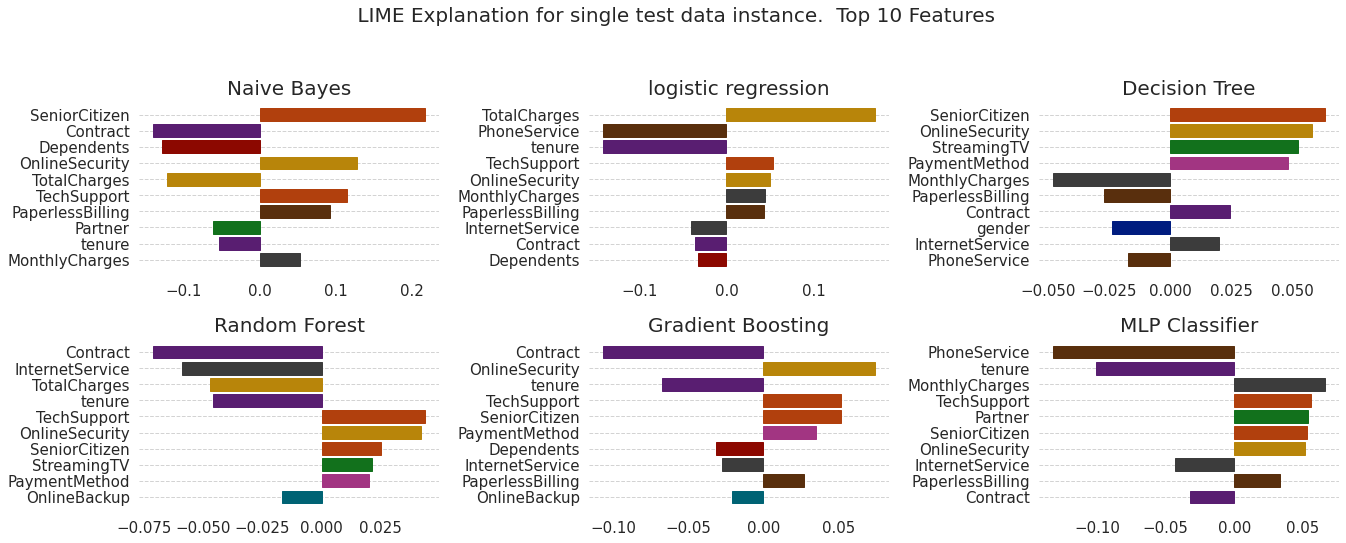

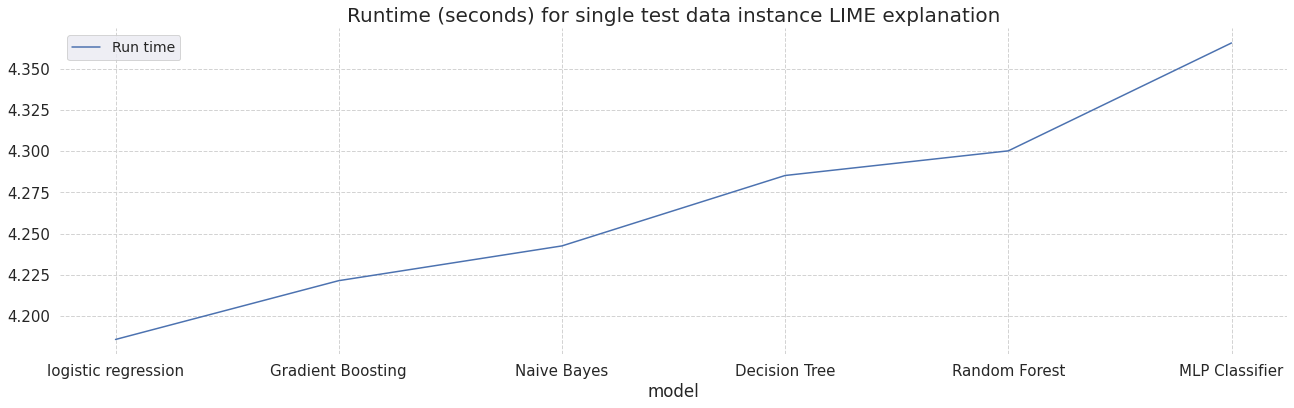

In [13]:
def plot_lime_exp(fig, fig_index, exp_data, title):
    features = list(exp_data.keys())[::-1]
    explanations = list(exp_data.values())[::-1]
    ax = fig.add_subplot(int(fig_index))
    lime_bar = ax.barh(features, explanations)
    ax.set_title(title, fontsize=20)
    for i, bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])
        plt.box(False)


fig = plt.figure(figsize=(19, 8))

# Plot lime explanations for trained models
for i, dex in enumerate(lime_data_explainations):
    fig_index = "23" + str(i + 1)
    plot_lime_exp(fig, fig_index, lime_data_explainations[i], trained_models[i]["name"])

plt.suptitle(
    " LIME Explanation for single test data instance.  Top " + str(top_x) + " Features",
    fontsize=20,
    fontweight="normal",
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot run time for explanations
lx_df = pd.DataFrame(lime_explanation_time)
lx_df.sort_values("time", inplace=True)
setup_plot()
lx_ax = lx_df.plot(
    kind="line",
    x="model",
    title="Runtime (seconds) for single test data instance LIME explanation",
    figsize=(22, 6),
)
lx_ax.title.set_size(20)
lx_ax.legend(["Run time"])
plt.box(False)

## Debugging  LIME: Should I trust the Explanation?


Underneath, the LIME algorithm uses an approximate linear model to derive local explanations. Like any other ML model, this explanation model can have *issues* too. So, what can we do to build   confidence in the quality of an explanation. As a first step, we can check if the local model is indeed a good approximator for the original model.    

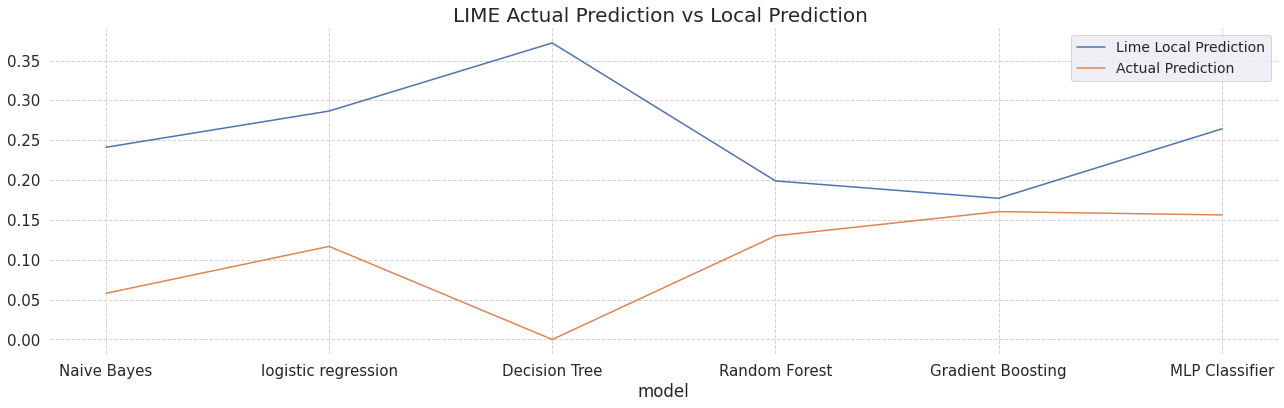

In [14]:
# Plot run time for explanations
lime_metrics_df = pd.DataFrame(lime_metrics)
lime_metrics_df_ax = lime_metrics_df[["lime class1", "actual class1", "model"]].plot(
    kind="line",
    x="model",
    title="LIME Actual Prediction vs Local Prediction ",
    figsize=(22, 6),
)
lime_metrics_df_ax.title.set_size(20)
lime_metrics_df_ax.legend(["Lime Local Prediction", "Actual Prediction"])
plt.box(False)

The plot above shows the predictions made by the LIME local model and the original model for the explained data instance. Both numbers should be close.  When they are not, this may raise questions as to if we can trust the explanation. There are few things that can be done:
-  Modify the parameters of LIME to yield a better explanation. E.g. increase the number of perturbations (LIME ) or kernel width (see related discussion  [here](https://github.com/marcotcr/lime/issues/209)), 
- Improve our original model (In this case, we know that the Decision Tree shows signs of overfitting). 

The next explanation method we will consider (SHAP) aims to address such inconsistencies. Let's go!

## Explanations with SHAP

To provide some intuition on how SHAP works, consider the following scenario. We have a group of data scientists (Sarah, Jessica, and Patrick) who collaborate to build a great predictive model for their company. At the end of the year, their efforts result in an increase in profit of which $5 million must now be shared amongst our 3 heroes. Assuming we have good ways to measure (or simulate) the contributions of each data scientist, how can we allocate this profit such that each person is fairly rewarded commensurate to their actual contribution?


[Shapley values](https://en.wikipedia.org/wiki/Shapley_value) provide a method for this specific type of allocation (collaborative multiplayer game setting) with a set of desirable axiomatic properties (Efficiency, Symmetry, Linearity, Anonymity, Marginalism) that guarantee fairness. These values are computed by computing the average marginal contribution of each person across all possible orderings. For example, imagine we assign only Sarah to the project and note the increase in profit (their marginal contribution). We then add Jessica and note the corresponding increase. We then add Patrick and note their contribution. This is repeated for all possible orderings (e.g. {Patrick, Jessica, Sarah}, {Jessica, Sarah, Patrick}, etc ) and the average marginal contribution for each person is computed.
Extending this to machine learning, we can think of each feature as comparable to our data scientists and the model prediction as the profits. To explain our model, we repeatedly add each feature and note its marginal contribution to model prediction. Importantly, we want to use the Shapley values to assign credit to each feature, because they provide two important guarantees (e.g., LIME, Feature Permutation, Feature Importance) that other methods do not provide:


- local accuracy (an approximate model used to explain the original model should match the output of the original model for a given input)
- consistency (if the original model changes such that a feature has a larger impact in every possible ordering, then its attribution should not decrease)



In practice, a few simplifications are required to compute Shapley values. Perhaps the most important is related to how we simulate the adding or removal of features while computing model prediction. This is challenging because there is no straightforward way to "remove" a feature for most predictive models at test time. We can either replace the feature with its mean value, median value. In the SHAP library implementation, a “missing” feature is simulated by replacing the feature with the values it takes in the background dataset. 


## The SHAP Library Implementation.

The SHAP library contains implementations for several types of explanations that leverage Shapley values. These include the `TreeExplainer` which is optimized (and fast) for tree based models; `DeepExplainer` and `GradientExplainer` for neural networks; and  `KernelExplainer`, which makes no assumptions about the underlying model to be explained (model agnostic like LIME).

To explain a model on a test set using `KernelExplainer`, the SHAP library api is as follows:

```
import shap
explainer = shap.KernelExplainer(model.predict_proba, background_data)
shap_values = explainer.shap_values(X_test)
```

To unpack and understand the results from SHAP KernelExplainer, there are a few terms worth clarifying.


| Variable 	| Description 	|
|--------------------------	|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| model 	| the model to be explained 	|
| background_data 	| This is a required argument to KernelExplainer. Since most models aren’t designed to handle arbitrary missing data at test time, SHAP simulates a “missing” feature by replacing it with the values it takes in the background dataset. For small problems, this background dataset can be the whole training set, but for larger problems, it is suggested that a subsample of the training set (or the kmeans function to summarize the dataset) is used. Background data is optional for tree-based models. 	|
| explainer.expected_value 	| This is a field in the explainer object is displayed as the baseline in a SHAP force plot. It should be the same as the mean of the model output over the background dataset. One simple task which I found to be useful is to manually compute the mean prediction on the background dataset and see how it corresponds to the expected value output by SHAP. 	|
| shap_values 	| The shap_values returned by the explainer object are a measure of how each feature contributes to the difference between the model’s expected value and the prediction for that instance. The units of the Shapley values are in the units of the target variable. The sum of the shap values should be equal to the difference between the base value and the model prediction. 	|




## Kernel Explainer



In [15]:
current_model = trained_models[3]  # Explain the Random Forest Model
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]
scaled_train_data = scaler.transform(X_train)
sub_sampled_train_data = shap.sample(
    scaled_train_data, 600, random_state=0
)  # use 600 samples of train data as background data

scaled_test_data = scaler.transform(X_test)
subsampled_test_data = scaled_test_data[test_data_index].reshape(1, -1)

start_time = time.time()
explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data, l1_reg="aic")
elapsed_time = time.time() - start_time

# explain first sample from test data
print(
    "Kernel Explainer SHAP run time",
    round(elapsed_time, 3),
    " seconds. ",
    current_model["name"],
)
print("SHAP expected value", explainer.expected_value)
print("Model mean value", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][0],
    subsampled_test_data[0],
    feature_names=X_train.columns,
)

Using 600 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1/1 [00:29<00:00, 29.50s/it]

Kernel Explainer SHAP run time 29.562  seconds.  Random Forest
SHAP expected value [0.71930373 0.28069627]
Model mean value [0.73105118 0.26894882]
Model prediction for test data [[0.87 0.13]]


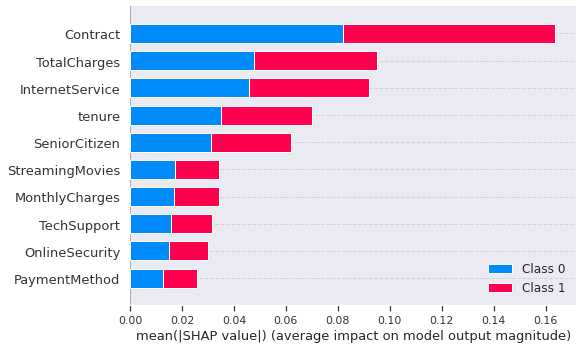

In [18]:
shap.initjs()
shap.summary_plot(
    shap_values, subsampled_test_data, feature_names=X_train.columns, max_display=10
)

## Tree Explainer



TreeExplainer on random forests takes about 0.091 seconds. This is compared to > 12.15 seconds required by KernelExplainer ( > **100x** faster).

In [19]:
current_model = trained_models[3]
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]

scaled_test_data = scaler.transform(X_test)
subsampled_test_data = scaled_test_data[test_data_index].reshape(1, -1)

# explain first sample from test data
start_time = time.time()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(subsampled_test_data)
elapsed_time = time.time() - start_time

print(
    "Tree Explainer SHAP run time",
    round(elapsed_time, 3),
    " seconds. ",
    current_model["name"],
)
print("SHAP expected value", explainer.expected_value)
print("Model mean value", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][0],
    subsampled_test_data[0],
    feature_names=X_train.columns,
)

Tree Explainer SHAP run time 0.198  seconds.  Random Forest
SHAP expected value [0.7335419 0.2664581]
Model mean value [0.73105118 0.26894882]
Model prediction for test data [[0.87 0.13]]


## Kernel Explainer - Explain a test data instance for all models

In the following section, we will generate and visualize explanations using the SHAP KernelExplainer for a given data point in our test set (same as we did for LIME). 

In [ ]:
def get_kernel_shap_explainer(model, background_data, train_data):
    shap_explainer = shap.KernelExplainer(model.predict_proba, background_data)
    return shap_explainer


def shap_explain(explainer, test_data):
    shap_values = explainer.shap_values(test_data, l1_reg="aic")
    return shap_values


shap_data_explainations = []
shape_explanation_time = []
feat_names = list(current_data.columns)
data_subsample = 500

for current_model in trained_models:
    scaler = current_model["model"]["scaler"]
    scaled_test_data = scaler.transform(X_test)
    scaled_train_data = scaler.transform(X_train)
    sampled_scaled_train_data = shap.sample(
        scaled_train_data, data_subsample
    )  # subsample background data to make things faster

    start_time = time.time()
    shap_explainer = get_kernel_shap_explainer(
        current_model["model"]["clf"], sampled_scaled_train_data, scaled_train_data
    )

    # explain first sample from test data
    sampled_scaled_test_data = scaled_test_data[test_data_index].reshape(1, -1)
    shap_values = shap_explain(shap_explainer, sampled_scaled_test_data)
    elapsed_time = time.time() - start_time
    idx = np.argsort(np.abs(shap_values[1][0]))[::-1]
    ex_holder = {feat_names[idx[i]]: shap_values[1][0][idx[i]] for i in range(top_x)}

    shap_data_explainations.append(ex_holder)
    shape_explanation_time.append(
        {"time": elapsed_time, "model": current_model["name"]}
    )

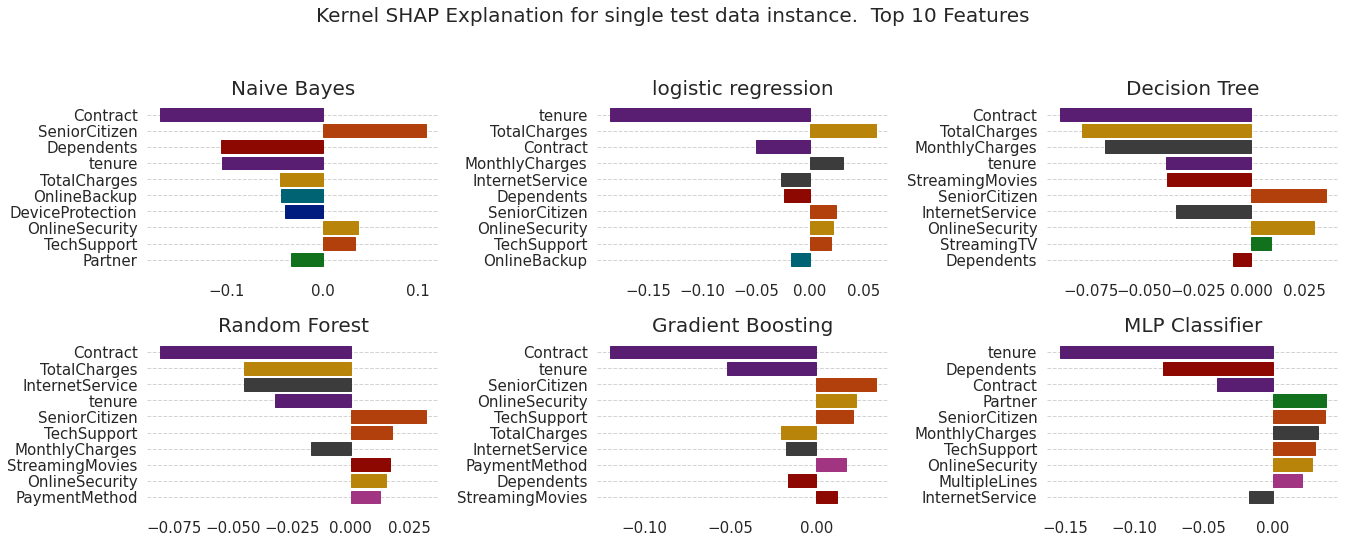

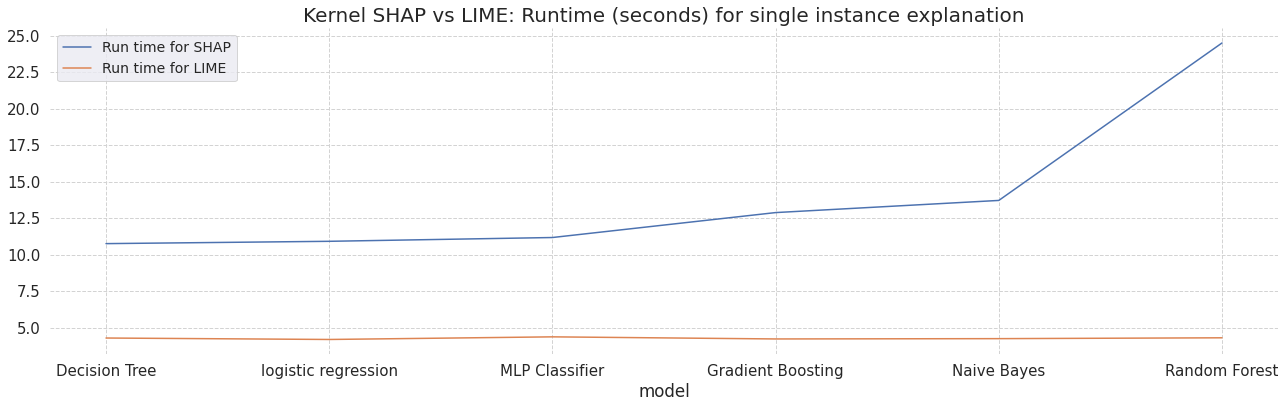

In [21]:
def plot_shap_exp(fig, fig_index, exp_data, title):
    features = list(exp_data.keys())[::-1]
    explanations = list(exp_data.values())[::-1]
    ax = fig.add_subplot(int(fig_index))
    lime_bar = ax.barh(features, explanations)
    ax.set_title(title, fontsize=20)
    for i, bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])
        plt.box(False)


# Plot SHAP explanations for a given test set item
fig = plt.figure(figsize=(19, 8))
for i, dex in enumerate(shap_data_explainations):
    fig_index = "23" + str(i + 1)
    plot_lime_exp(fig, fig_index, shap_data_explainations[i], trained_models[i]["name"])

plt.suptitle(
    "Kernel SHAP Explanation for single test data instance.  Top "
    + str(top_x)
    + " Features",
    fontsize=20,
    fontweight="normal",
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot SHAP explanation run time
shapx_df = pd.DataFrame(shape_explanation_time)
shapx_df.sort_values("time", inplace=True)


# Plot both LIME and SHAP explanation run times
m_df = shapx_df.merge(lx_df, on="model", suffixes=("_SHAP", "_LIME"))
m_df.head()
mx_df_ax = m_df.plot(
    kind="line",
    x="model",
    title="Kernel SHAP vs LIME: Runtime (seconds) for single instance explanation",
    figsize=(22, 6),
)
mx_df_ax.title.set_size(20)
mx_df_ax.legend(["Run time for SHAP", "Run time for LIME"])
plt.box(False)

## Debugging SHAP KernelExplainer: Small background Dataset may lead to inconsistent expected value.

The process used by SHAP to simulate missing values draws from a background dataset (usually the training set). When the training dataset is large, the authors of SHAP suggest the use of a subsample of the training set as background data to reduce computation costs.  A side effect of using a small sub sample is that the expected value used by SHAP may differ from the model's mean value. The plots below compare the SHAP expected value and model mean prediction on training set for multiple background sample sizes.

- Run time increases (linearly) with increase in size of background dataset
- Expected value is closer to mean value on enter train set as the size of background subsample increases. (ideally these numbers should be the same. See relevant  [discussion on Github](https://github.com/slundberg/shap/issues/352))

The above results raise some questions as to the quality of explanations when a subsample is used as background data for SHAP. It is important to note that the TreeExplainer sidesteps this issue as it does not require a background dataset. Per the SHAP documentation

```
This argument (background data) is optional when feature_perturbation=”tree_path_dependent”, since in that case we can use the number of training samples that went down each tree path as our background dataset (this is recorded in the model object).
```

In [ ]:
current_model = trained_models[3]
clf = current_model["model"]["clf"]
scaler = current_model["model"]["scaler"]

sample_sizes = [50, 100, 150, 200, 300, 600, 1000, 2000, 3000]
metric_holder = []


for sample_size in sample_sizes:
    scaled_train_data = scaler.transform(X_train)
    sub_sampled_train_data = shap.sample(
        scaled_train_data, sample_size, random_state=0
    )  # use x samples of train data as background data

    scaled_test_data = scaler.transform(X_test)
    test_data_index = 10
    subsampled_test_data = scaled_test_data[test_data_index].reshape(1, -1)

    start_time = time.time()
    explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)
    shap_values = explainer.shap_values(subsampled_test_data, l1_reg="aic")
    elapsed_time = time.time() - start_time

    metric_holder.append(
        {
            "class0 exp": explainer.expected_value[0],
            "class1 exp": explainer.expected_value[1],
            "run time": elapsed_time,
            "sample size": sample_size,
        }
    )

metric_df = pd.DataFrame(metric_holder)

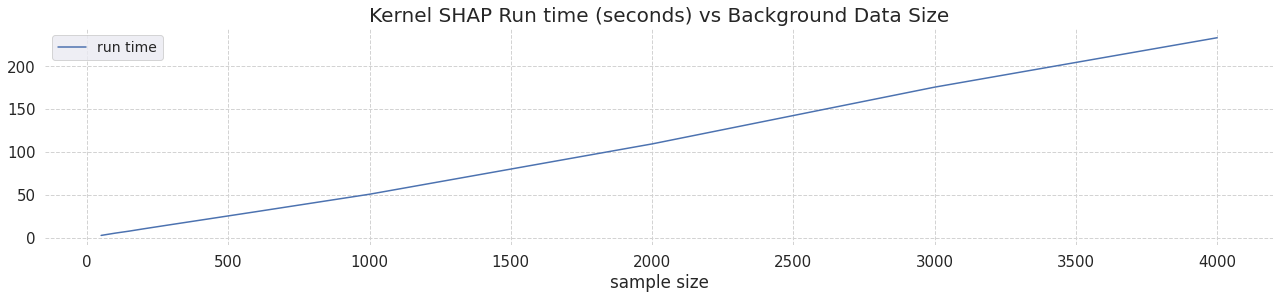

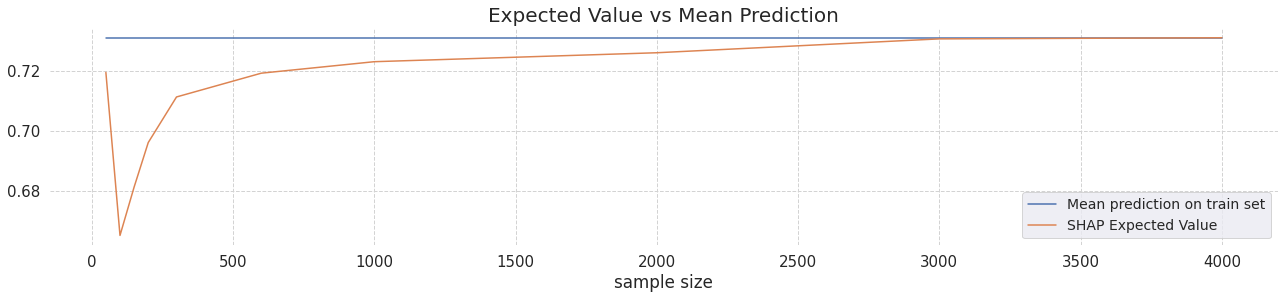

In [23]:
mean_pred = clf.predict_proba(scaled_train_data).mean(axis=0)
metric_df["mean prediction class0"] = mean_pred[0]
metric_df["mean prediction class1"] = mean_pred[1]
metric_df.head()
setup_plot()
metrix_ax = metric_df[["sample size", "run time"]].plot(
    kind="line",
    x="sample size",
    title="Kernel SHAP Run time (seconds) vs Background Data Size",
    figsize=(22, 4),
)
metrix_ax.title.set_size(20)
plt.box(False)

setup_plot()
metrix_ax = metric_df[["sample size", "mean prediction class0", "class0 exp"]].plot(
    kind="line",
    x="sample size",
    title="Expected Value vs Mean Prediction",
    figsize=(22, 4),
)
metrix_ax.title.set_size(20)
metrix_ax.legend(["Mean prediction on train set", "SHAP Expected Value"])
plt.box(False)

## LIME vs SHAP : When to use what?

LIME and SHAP are both good methods for explaining models. In theory, SHAP is the better approach as it provides mathematical guarantees for the accuracy and consistency of explanations. In practice, the model agnostic implementation of SHAP (KernelExplainer) is slow, even with approximations. This speed issue is of much less concern if you are using a tree based model and can take advantage of the optimizations implemented in SHAP TreeExplainer (we saw it could be up to 100x faster than KernelExplainer).

Some additional limitations of both methods are mentioned below

- LIME is not designed to work with one hot encoded data. Considering that each data point is perturbed to create the approximate model, perturbing a one hot encoded variable may result in unexpected (meaningless) features. See discussion [here](https://github.com/marcotcr/lime/issues/153)
- LIME depends on the ability to perturb samples in meaningful ways. This perturbation is use case specific. E.g., for tabular data, this entails adding random noise to each feature; for images, this entails replacing superpixels within the image with some mean value or zeroes; for text, this entails removing words from the text. It is often useful to think through any side effects of these perturbation strategies with respect to your data to further build trust in the explanation.
- In some cases, the local model built by LIME may fail to approximate the behaviour of the original model. It is good practice to check for such inconsistencies before trusting LIME explanations. 

- LIME works with models that output probabilities for classification problems. Models like SVMs are not particularly designed to output probabilities (though they can be coerced into this with some [issues](https://scikit-learn.org/stable/modules/svm.html).). This may introduce some bias into the explanations.

- SHAP depends on background datasets to infer a baseline/expected value. For large datasets, it is computationally expensive to use the entire dataset and we have to rely on appromixations (e.g. subsample the data). This has implications for the accuracy of the explanation.

- SHAP explains the deviation of a prediction from the expected/baseline value which is estimated using the training dataset. Depending on the specific use case, it may be more meaningful to compute the expected value using a specific subset of the training set as opposed to the entire training set. For example, it may be more meaningful to explain a churn prediction with respect to how it deviates from customers who did not churn. Here, we might want to use the dataset of customers who did not churn as our background dataset.  See this issue [here](https://github.com/slundberg/shap/issues/435).

## Conclusion and Further Reading 

In this notebook, we have looked at LIME and SHAP. Actually, we have looked at just subsets of both of these remarkable tools, focusing on explaining models built on tabular data.  It is worth noting that  these methods can be extended to work on text, and image data as well. For additional reading on other interpretability methods, the [Interpretable ML book by  Christoph Molnar  is recommended](https://christophm.github.io/interpretable-ml-book/).

- Interpretability - Cloudera Fast Forward Labs https://ff06-2020.fastforwardlabs.com/
- SHAP vs Integrated Gradients https://blog.fiddler.ai/2019/08/should-you-explain-your-predictions-with-shap-or-ig/
- Interpretable Machine Learning https://christophm.github.io/interpretable-ml-book/


_**If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices. A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).**_